<h1>Medical Report Generation From X-Ray Images :</h1>


<h2>Business Problem/Problem Statement :</h2>

> Clinical imaging captures enormous amounts of information but most radio-logic data are reported in qualitative and subjective terms. X-Rays are a form of Electromagnetic Radiation that is used for medical imaging. Analysis of X-ray reports is a very important task of radiologists and pathologists to recommend the correct diagnosis to the patients. In this project, we are tackling the image captioning problem for a dataset containing Chest X-ray images. With the help of the state of the art deep learning architecture and optimizing parameters of the architecture. The problem statement here is to find the impression from the given chest X-Ray images. These images are in two types: Frontal and Lateral view of the chest. With these two types of images as input we need to find the impression for given X-Ray. To resolve this problem statement, we will be building a predictive model which involves both image and text processing to build a deep learning model. Image captioning is an interesting problem, where we can learn both Natural Language Processing(NLP) and Computer Vision(CV) techniques.

<h2>Dataset Overview :</h2>

Original data source : https://openi.nlm.nih.gov/

The dataset contains chest X-ray images and radiology text reports. Each image has been paired with four captions such as Impressions, Findings, Comparison and Indication that provide clear descriptions of the salient entities and events.

> Chest X-ray -There are 7,471 images in .png file format (contain lateral view and frontal view of each patient).

> Radiology Report -There are about 3955 patients text reports available in .XML format.

<h2>Mapping the real-world problem to Machine Learning problem :</h2>

> The problem we are going to solve in this case study is Medical Image Captioning. Basically, we have to extract features from images using a Convolutional Neural Network(CNN) from scratch or using transfer learning (preferable as we have less amount of data). Then use these extracted features to predict the captions LSTMs or GRUs. The output would be a sequence of words.

<h2>Real-world constraints :</h2>

> Interpretability is moderately important.

> There are no latency constraints.

> As the cost of mistakes in the Medical domain is very high the model should be very good in its predictions. 


<h2>Performance Metric :</h2>

> To evaluate the model performance, I will use bilingual evaluation understudy (BLEU) score. BLEU is a well-acknowledged metric to measure the similarity of one hypothesis sentence to multiple reference sentences. Given a single hypothesis sentence and multiple reference sentences, it returns value between 0 and 1. The metric close to 1 means that the two are very similar. Apparently we need to have a higher BLEU score.


**P.S : Initially, I made this notebook on google colab. So, I have used the data from original source by manually uploading it on kaggle, just to keep the path same. We can use the given dataset as well.**

**Import all the libraries :**

In [48]:
import os
import re
import cv2
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
sns.set_style("whitegrid")
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
warnings.filterwarnings('ignore')
import xml.etree.ElementTree as ET
from wordcloud import WordCloud, ImageColorGenerator

In [3]:
cwd = os.getcwd()

In [4]:
import tarfile
images = tarfile.open('../input/images/NLMCXR_png.tgz')
images.extractall(cwd+'/xray_images/')

In [5]:
xml = tarfile.open('../input/reports/NLMCXR_reports.tgz')
xml.extractall(cwd+'/xray_reports/')

**Below is the sample image and the report :**


![](https://i.imgur.com/PWo3x47.png)

**Display an XML :**

In [6]:
with open("./xray_reports/ecgen-radiology/1.xml", 'r') as f:
    print(f.read())

<?xml version="1.0" encoding="utf-8"?>
<eCitation>
   <meta type="rr"/>
   <uId id="CXR1"/>
   <pmcId id="1"/>
   <docSource>CXR</docSource>
   <IUXRId id="1"/>
   <licenseType>open-access</licenseType>
   <licenseURL>http://creativecommons.org/licenses/by-nc-nd/4.0/</licenseURL>
   <ccLicense>byncnd</ccLicense>
   <articleURL/>
   <articleDate>2013-08-01</articleDate>
   <articleType>XR</articleType>
   <publisher>Indiana University</publisher>
   <title>Indiana University Chest X-ray Collection</title>
   <note>The data are drawn from multiple hospital systems.</note>
   <specialty>pulmonary diseases</specialty>
   <subset>CXR</subset>
   <MedlineCitation Owner="Indiana University" Status="supplied by publisher">
   
      <Article PubModel="Electronic">
      
         <Journal>
         
            <JournalIssue>
            
               <PubDate>
               
                  <Year>2013</Year>
               
                  <Month>08</Month>
               
            

**Observations :**

The fields which seem to be important and userful are :

* pmcid : Patient id
* COMPARISION
* INDICATION
* FINDINGS
* IMPRESSIONS (Target Variable)
* Image id

We can see there are two image files associated with this report. First I will check the stats of data. Then we will see the maximum and minimum possible value for number of images that are associated with a report.

**Checking the data stats :**

In [7]:
print('Total Images in data : ', len(os.listdir('./xray_images')))
print('Total Reports in data : ', len(os.listdir('./xray_reports/ecgen-radiology')))

Total Images in data :  7471
Total Reports in data :  3955


Observations :

* There are 7471 images(X-rays) and 3955 reports in dataset.
* Few reports have more than image associated with them.

In [8]:
#list of count of images
img_count = [] 
for file in os.listdir('./xray_reports/ecgen-radiology'):
  xml_file = os.path.join('./xray_reports/ecgen-radiology',file)
  #reading the xml data
  with open(xml_file, 'r') as f:  
    data = f.read()
  #getting all the image names
  regex = r"parentImage id.*" 
  k  = re.findall(regex,data)
  temp = len(k)
  img_count.append(temp)

print("The max number of images associated with a report:",np.array(img_count).max())
print("The min number of images associated with a report:",np.array(img_count).min())

The max number of images associated with a report: 5
The min number of images associated with a report: 0


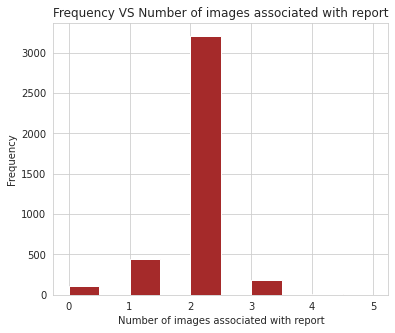

In [49]:
plt.figure(figsize = (6,5))
ax = pd.Series(img_count).plot(kind='hist',color='brown')
ax.set_xlabel('Number of images associated with report')
ax.set_title("Frequency VS Number of images associated with report")
plt.show()

In [10]:
print("Images per patient :\n")
print(pd.Series(img_count).value_counts())

Images per patient :

2    3208
1     446
3     181
0     104
4      15
5       1
dtype: int64


**Observation :**

We can see that the maximum number of images associated with a report can be 5 while the minimum is 0. The highest frequecy of being associated with a report are 2 images.

**Dataset Preparation :**

Reports are in xml format. Need to do xml parsing to read the data and convert it into csv format.

> **Input Features :** Images and we will also take abstract, comparison, indication, findings as text input features.

> **Target variable :** Impression (Text feature).

In [11]:
#Reference : https://stackoverflow.com/questions/2723015/how-to-find-recursively-for-a-tag-of-xml-using-lxml

columns = ["image_name", "image_caption", "comparison", "indication", "findings", "impression"]
dataframe = pd.DataFrame(columns = columns)
for file in tqdm(os.listdir('./xray_reports/ecgen-radiology/')):
    #find files with .xml extension only
    if file.endswith(".xml"):
        # finding root element 
        tree = ET.parse('./xray_reports/ecgen-radiology/'+file)#parse the xml file
        
        findings = tree.find(".//AbstractText[@Label='FINDINGS']").text
        indication = tree.find(".//AbstractText[@Label='INDICATION']").text
        comparision = tree.find(".//AbstractText[@Label='COMPARISON']").text
        impression = tree.find(".//AbstractText[@Label='IMPRESSION']").text

        caption = set()
        name_img = set()
        #find images in each parentImage tag
        for iterator in tree.findall("parentImage"):
            img = iterator.attrib['id']+".png"
            name_img.add(img)
            #add the corresponding report for each image
            caption.add('' if iterator.find('caption').text is None else iterator.find('caption').text)
            
        # add image details and reports to dataframe
        dataframe = dataframe.append(pd.Series([','.join(name_img), ','.join(caption), comparision, indication, findings, impression],
                                                         index = columns), ignore_index = True)


100%|██████████| 3955/3955 [00:14<00:00, 275.62it/s]


In [12]:
dataframe.head()

,image_name,image_caption,comparison,indication,findings,impression
0,"CXR549_IM-2153-1001.png,CXR549_IM-2153-2001.png",Two views of the chest,XXXX.,XXXX,Stable appearance of the left upper lung lobe ...,1. No acute cardiopulmonary process. 2. Stable...
1,"CXR39_IM-1978-1002.png,CXR39_IM-1978-1001.png","CHEST 2V FRONTAL/LATERAL XXXX, XXXX XXXX PM","XXXX, XXXX.",diminished breath sounds throughout,The heart and lungs have XXXX XXXX in the inte...,No active disease.
2,"CXR934_IM-2432-2001.png,CXR934_IM-2432-1001.png",PA AND LATERAL VIEWS OF THE CHEST dated XXXX a...,None.,Asthma,Cardiomediastinal silhouette is within normal ...,1. Heart failure with pulmonary edema.
3,CXR520_IM-2131-1001.png,Xray Chest PA and Lateral,None,The patient is a XXXX-year-old male with atria...,"No pneumothorax, pleural effusion or airspace ...",No acute cardiopulmonary abnormality. .
4,"CXR365_IM-1812-1002.png,CXR365_IM-1812-1001.png",CHEST- PA AND LATERAL,None,Chest pain after XXXX,The lungs are clear. The cardiomediastinal sil...,No evidence of thoracic injury.


In [13]:
# Shape of the DataFrame
print('Shape of the Dataframe : ', dataframe.shape)

Shape of the Dataframe :  (3955, 6)


**Preprocessing :**

In [14]:
# function for obtaining the different information part of the xml report file and preprocessing them and also adding the concernced image and report information to the dataframe
def decontracted(phrase): #https://stackoverflow.com/a/47091490
  """
  performs text decontraction of words like won't to will not
  """
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase


In [15]:
def preprocess_text(data): #https://regex101.com/
  """
  extracts the information data from the xml file and does text preprocessing on them
  here info can be 1 value in this list ["COMPARISON","INDICATION","FINDINGS","IMPRESSION"]
  """
  preprocessed = []

  for sentence in tqdm(data.values):

    sentence = BeautifulSoup(sentence, 'lxml').get_text()

    regex = r"\d." 
    sentence = re.sub(regex,"",sentence) #removing all values like "1." and "2." etc

    regex = r"X+"
    sentence = re.sub(regex,"",sentence) #removing words like XXXX

    regex = r"[^.a-zA-Z]" 
    sentence = re.sub(regex," ",sentence) #removing all special characters except for full stop

    regex = r"http\S+"
    sentence = re.sub(regex,"", sentence)
    sentence = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?$%^&*'/+\[\]_]+", "", sentence)
    sentence = re.sub('&', 'and',sentence)
    sentence = re.sub('@', 'at',sentence)
    sentence = re.sub('0', 'zero',sentence)
    sentence = re.sub('1', 'one',sentence)
    sentence = re.sub('2', 'two',sentence)
    sentence = re.sub('3', 'three',sentence)
    sentence = re.sub('4', 'four',sentence)
    sentence = re.sub('5', 'five',sentence)
    sentence = re.sub('6', 'six',sentence)
    sentence = re.sub('7', 'seven',sentence)
    sentence = re.sub('8', 'eight',sentence)
    sentence = re.sub('9', 'nine',sentence)
    sentence = re.sub('year old', "", sentence)#Occur multiple times in Indication feature but not necessary     
    sentence = re.sub('yearold', "", sentence)
    sentence = decontracted(sentence) #perform decontraction
    sentence = sentence.strip().lower() #strips the begining and end of the string of spaces and converts all into lowercase
    sentence = " ".join(sentence.split()) #removes unwanted spaces
    if sentence=="": #if the resulting sentence is an empty string return null value
      sentence = np.nan
    preprocessed.append(sentence)
  return preprocessed

In [16]:
#Check for Null values in Text columns
NaN = dataframe.isnull().sum()
print("Total Nan Values in caption columns -",NaN[1])
print("Total Nan Values in comparison columns -",NaN[2])
print("Total Nan Values in Indication columns -",NaN[3])
print("Total Nan Values in findings columns   -",NaN[4])
print("Total Nan Values in Impression columns -",NaN[5])

Total Nan Values in caption columns - 0
Total Nan Values in comparison columns - 622
Total Nan Values in Indication columns - 90
Total Nan Values in findings columns   - 530
Total Nan Values in Impression columns - 34


In [21]:
#Replacing the nan values
dataframe['image_caption'] = dataframe['image_caption'].fillna('Unknown')
dataframe['comparison'] = dataframe['comparison'].fillna('No Comparison')
dataframe['indication'] = dataframe['indication'].fillna('No Indication')
dataframe['findings'] = dataframe['findings'].fillna('No Findings')
dataframe['impression'] = dataframe['impression'].fillna('No Impression')

In [18]:
#Check for Null values in Text columns
NaN = dataframe.isnull().sum()
print("Total Nan Values in caption columns -",NaN[1])
print("Total Nan Values in comparison columns -",NaN[2])
print("Total Nan Values in Indication columns -",NaN[3])
print("Total Nan Values in findings columns   -",NaN[4])
print("Total Nan Values in Impression columns -",NaN[5])

Total Nan Values in caption columns - 0
Total Nan Values in comparison columns - 0
Total Nan Values in Indication columns - 0
Total Nan Values in findings columns   - 0
Total Nan Values in Impression columns - 0


In [22]:
#Preprocessing of text features
dataframe['image_caption'] = preprocess_text(dataframe['image_caption'])
dataframe['comparison'] = preprocess_text(dataframe['comparison'])
dataframe['indication'] = preprocess_text(dataframe['indication'])
dataframe['findings'] = preprocess_text(dataframe['findings'])
dataframe['impression'] = preprocess_text(dataframe['impression'])

100%|██████████| 3955/3955 [00:01<00:00, 3274.06it/s]


In [23]:
dataframe.head()

,image_name,image_caption,comparison,indication,findings,impression
0,"CXR549_IM-2153-1001.png,CXR549_IM-2153-2001.png",two views of the chest,no comparison,no indication,stable appearance of the left upper lung lobe ...,no acute cardiopulmonary process stable appear...
1,"CXR39_IM-1978-1002.png,CXR39_IM-1978-1001.png",chest frontal lateral pm,no comparison,diminished breath sounds throughout,the heart and lungs have in the interval both ...,no active disease
2,"CXR934_IM-2432-2001.png,CXR934_IM-2432-1001.png",pa and lateral views of the chest dated at hours,none,asthma,cardiomediastinal silhouette is within normal ...,heart failure with pulmonary edema
3,CXR520_IM-2131-1001.png,ray chest pa and lateral,no comparison,the patient is a male with atrial flutter hype...,no pneumothorax pleural effusion or airspace c...,no acute cardiopulmonary abnormality
4,"CXR365_IM-1812-1002.png,CXR365_IM-1812-1001.png",chest pa and lateral,none,chest pain after,the lungs are clear the cardiomediastinal silh...,no evidence of thoracic injury


**Observation :** 

* I did some text preprocessing in XML, for four labels (comparision,indcation, impression and findings). I analyze the text data, then perform tasks like decontraction (can't ---> can not), remove special character, convert in lowercase.

* I have also preprocessed Image caption feature, For getting additional information about the corrosponding image.

* Missing values are also present in image_name feature. As at some place nothing is assigned on image_name.

In [24]:
dataframe.replace("", float("NaN"), inplace=True)

In [25]:
#percentage missing values
print(dataframe.isnull().sum()*100/dataframe.shape[0] )

image_name       2.629583
image_caption    0.000000
comparison       0.000000
indication       0.000000
findings         0.000000
impression       0.000000
dtype: float64


**Observation :** We can see that there are still missing values in the data. We could remove all rows where image_name are null since they represent below 3% of the total datapoints.

In [26]:
dataframe.dropna(subset = ["image_name"], inplace=True)
dataframe.shape

(3851, 6)

In [27]:
dataframe.head()

,image_name,image_caption,comparison,indication,findings,impression
0,"CXR549_IM-2153-1001.png,CXR549_IM-2153-2001.png",two views of the chest,no comparison,no indication,stable appearance of the left upper lung lobe ...,no acute cardiopulmonary process stable appear...
1,"CXR39_IM-1978-1002.png,CXR39_IM-1978-1001.png",chest frontal lateral pm,no comparison,diminished breath sounds throughout,the heart and lungs have in the interval both ...,no active disease
2,"CXR934_IM-2432-2001.png,CXR934_IM-2432-1001.png",pa and lateral views of the chest dated at hours,none,asthma,cardiomediastinal silhouette is within normal ...,heart failure with pulmonary edema
3,CXR520_IM-2131-1001.png,ray chest pa and lateral,no comparison,the patient is a male with atrial flutter hype...,no pneumothorax pleural effusion or airspace c...,no acute cardiopulmonary abnormality
4,"CXR365_IM-1812-1002.png,CXR365_IM-1812-1001.png",chest pa and lateral,none,chest pain after,the lungs are clear the cardiomediastinal silh...,no evidence of thoracic injury


**Add Image count feature :**

In [28]:
dataframe['image_count'] = dataframe['image_name'].astype(str).str.split(',').apply(len)

**Adding word count feature for indication, findings and impression :**


In [29]:
#Adding word count feature for indication, findings and impression
dataframe['indication_count'] = dataframe['indication'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
dataframe['findings_count'] = dataframe['findings'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
dataframe['impression_count'] = dataframe['impression'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
dataframe.head()

,image_name,image_caption,comparison,indication,findings,impression,image_count,indication_count,findings_count,impression_count
0,"CXR549_IM-2153-1001.png,CXR549_IM-2153-2001.png",two views of the chest,no comparison,no indication,stable appearance of the left upper lung lobe ...,no acute cardiopulmonary process stable appear...,2,2,57,11
1,"CXR39_IM-1978-1002.png,CXR39_IM-1978-1001.png",chest frontal lateral pm,no comparison,diminished breath sounds throughout,the heart and lungs have in the interval both ...,no active disease,2,4,18,3
2,"CXR934_IM-2432-2001.png,CXR934_IM-2432-1001.png",pa and lateral views of the chest dated at hours,none,asthma,cardiomediastinal silhouette is within normal ...,heart failure with pulmonary edema,2,1,57,5
3,CXR520_IM-2131-1001.png,ray chest pa and lateral,no comparison,the patient is a male with atrial flutter hype...,no pneumothorax pleural effusion or airspace c...,no acute cardiopulmonary abnormality,1,10,37,4
4,"CXR365_IM-1812-1002.png,CXR365_IM-1812-1001.png",chest pa and lateral,none,chest pain after,the lungs are clear the cardiomediastinal silh...,no evidence of thoracic injury,2,3,16,5


<h3>Exploring the Image features :</h3>

**Displaying sample 9 patient X-Ray :**

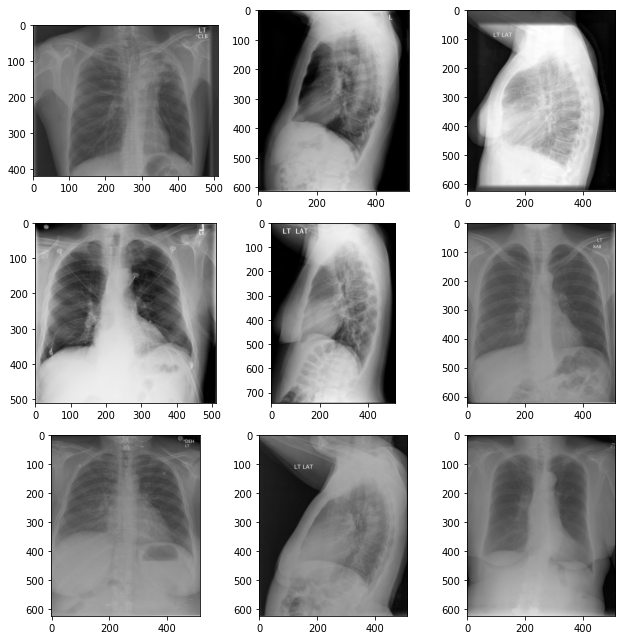

In [30]:
#Displaying sample 9 patient X-Ray
fig, axs = plt.subplots(3, 3, figsize = (9,9), tight_layout=True)
for row, figure in zip(dataframe[0:10].itertuples(), axs.flatten()):
    image=mpimg.imread("./xray_images/"+row.image_name.split(',')[0])
    figure.imshow(image)
plt.show()

**Displaying Sample Images + Caption :**

In [31]:
def show_image_captions(df,sample):
    '''This function prints the sample images and its other text features.
       Parameters :
       - df: dataframe
       - sample: Number of datapoints'''
    
    sampled_row = df.sample(sample)

    for count, row in sampled_row.iterrows():
        print("Caption :",row['image_caption'])
        imgs = row["image_name"].split(',')
        fig, axs = plt.subplots(1, len(imgs), figsize = (10,10), tight_layout=True)
        iterator = 0

        for img, figure in zip(imgs, axs.flat):
            image= mpimg.imread("./xray_images/"+img)
            imgplot = axs[iterator].imshow(image)
            iterator +=1
        
        plt.show()
        print("\nComparision :",row.get('comparision'))
        print("\nIndication :",row.get('indication'))
        print("\nFindings :",row.get('findings'))
        print("\nImpression :",row.get('impression'))
        print("="*100,'\n')

Caption : ray chest pa and lateral


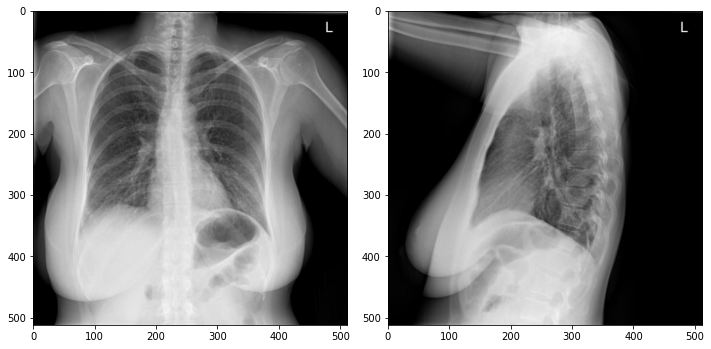


Comparision : None

Indication : and for about one shortness of breath started days ago some chest pain

Findings : no findings

Impression : heart size and mediastinal contour normal there is mild diffuse interstitial prominence worse in the right lung base this has developed in the interval and may represent atypical pneumonia more focal right base airspace disease may represent scar given the stability over time no lobar consolidation or effusion no pneumothorax

Caption : chest radiograph examination views performed at


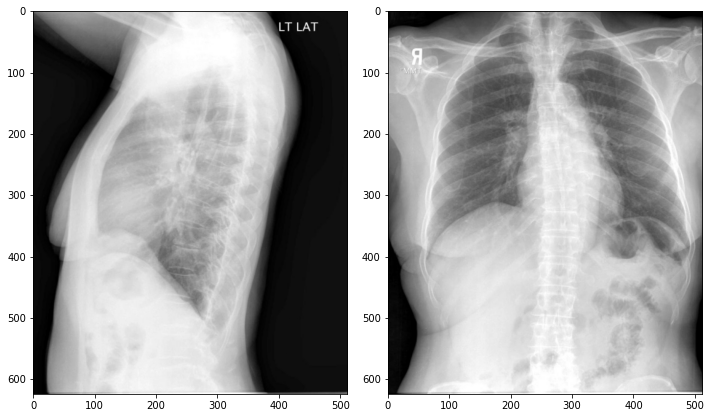


Comparision : None

Indication : female with chest pain

Findings : the cardiomediastinal silhouette is within normal limits for appearance the thoracic aorta is mildly tortuous and calcified no focal areas of pulmonary consolidation no pneumothorax no pleural effusion mild degenerative changes of the thoracic spine mild levoscoliosis of the thoracolumbar spine

Impression : no acute intrathoracic abnormality



In [32]:
#showing sample 2 datapoints
show_image_captions(dataframe, 2)

**Observations :**

* Images are in different shapes.
* All the X-Ray images are human upper body particularly about Chest part.

<h3>Exploring the Text features :</h3>

**Note :** For text feature analysis, I will not consider the "Comparision" label/feature. The reason behind this is, comparision label has most of its values as 'none' and 'no comparision' (which I had put in place of missing values). So, this will be not much helpful to predict the Target.

In [33]:
k = dataframe.loc[(dataframe.comparison == 'none') | (dataframe.comparison == 'no comparison')]
print("Number of rows with no informnation in comparision label:",k.shape[0])

Number of rows with no informnation in comparision label: 2805


**Observation :** Out of 3851 rows in data, 2805 rows have No Information in comparision feature/label.

**Feature Identification : Text or Categorical ?**

**Note :** It seems all of the text features are just text features. We can't consider any of them as categorical. We can confirm that by finding unique values and analysing them. Because if it is categorical, then we could get better predictions compared to giving it as a text feature.


In [34]:
def unique_words_features(df):
    '''This function takes pandas dataframe and show barplot of features unique and repeated words 
       Input  =  pandas dataframe or numpy arrays
       Output =  barplot of the unique words of dataframe '''

    #length of the feature
    len_total = len(df.tolist())

    #length of unique words in the featue
    len_unique = len(np.unique(df.tolist()))

    x = ['Total Values', 'Unique Values']
    y =  [len_total, len_unique]

    plt.bar(x,y,color = 'Teal')
    plt.ylabel('Word-Count')
    for index,data in enumerate(y):
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=15))
    
    plt.ylabel('Word-Count')

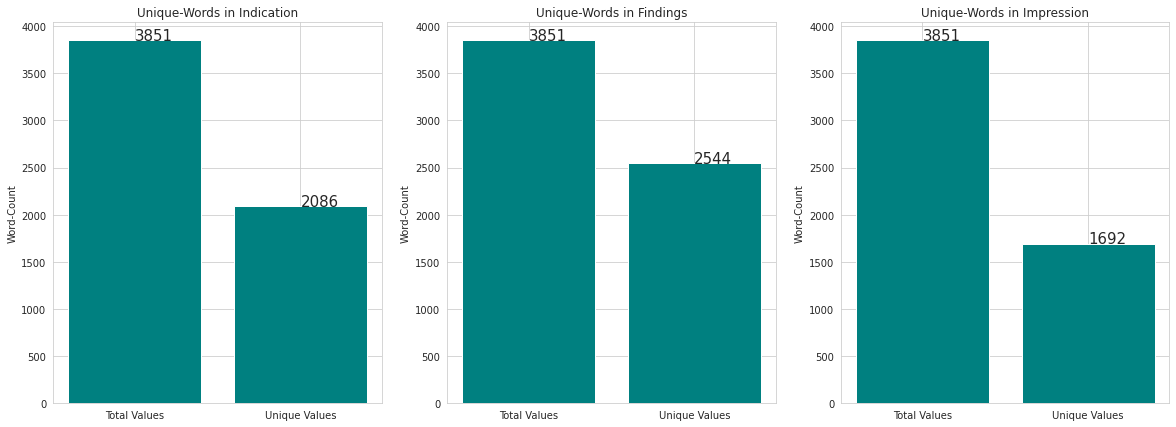

In [50]:
plt.figure(figsize = (20,7))
plt.subplot(131)
unique_words_features(dataframe['indication'])
plt.title('Unique-Words in Indication')
plt.subplot(132)
unique_words_features(dataframe['findings'])
plt.title('Unique-Words in Findings')
plt.subplot(133)
unique_words_features(dataframe['impression'])
plt.title('Unique-Words in Impression')
plt.show()

**Observation :** We conclude from above features bar plot, That all of them are text features as there are total 3851 entries and and a good chunk of values are unique in all of them i.e, They never repeated. So, they can not be categorical features.

**Analysis of Indication feature :**

In [36]:
#Printing min,max and median of word_count
print("Minimum number of word count for Indication is:",np.min(dataframe.indication_count.values))
print("Maximum number of word count for Indication is:",np.max(dataframe.indication_count.values))
print("median number of word count for Indication is:",np.median(dataframe.indication_count.values))

Minimum number of word count for Indication is: 1
Maximum number of word count for Indication is: 32
median number of word count for Indication is: 3.0


Plotting PDF and CDF for word_count distribution of Indication feature :

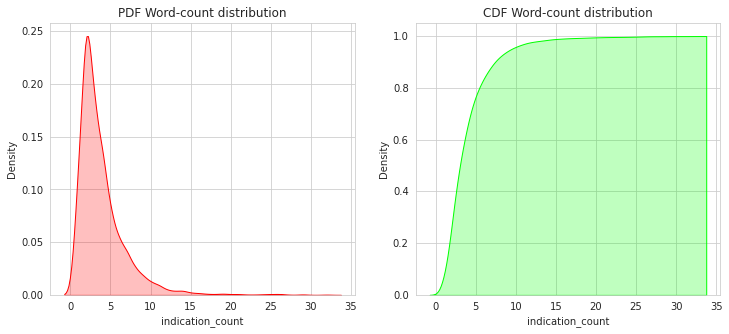

In [51]:
#Plotting PDF and CDF for word_count distribution of Indication feature
plt.figure(figsize = (12,5))
# Seaborn PDF
plt.subplot(121)
sns.kdeplot(dataframe['indication_count'],shade=True,color='Red')
plt.title("PDF Word-count distribution")
plt.subplot(122)
# Seaborn CDF
sns.distplot(dataframe['indication_count'], kde_kws={'cumulative': True,'shade': True}, hist=False,color='Lime')
plt.title("CDF Word-count distribution")
plt.show()

Top 50 frequent sentences of Indication feature :

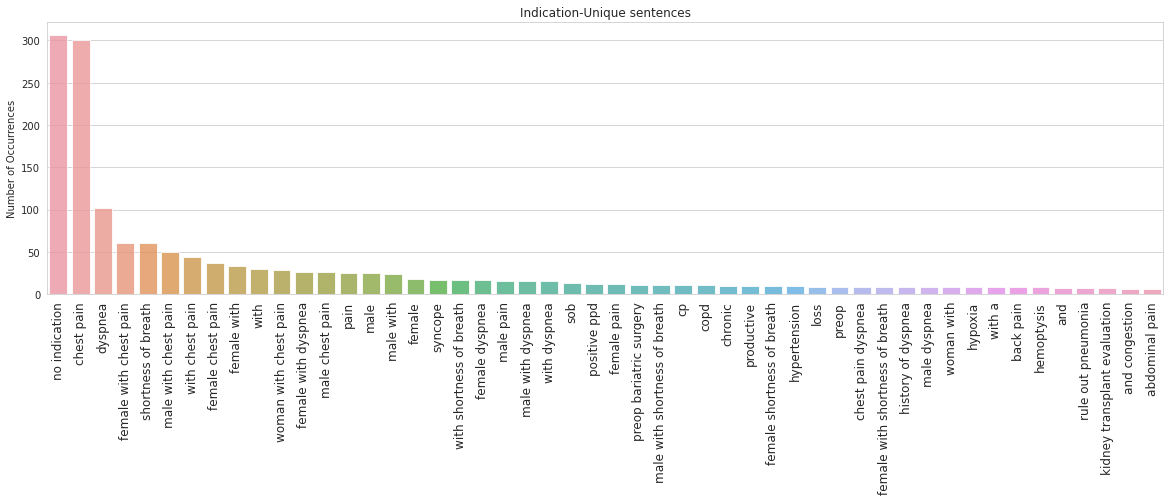

In [52]:
#Plotting top 50 frequent sentences of Indication feature
sentences = dataframe['indication'].value_counts()[:50]
plt.figure(figsize=(20,5))
sns.barplot(sentences.index, sentences.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xticks(fontsize='large',rotation=90)
plt.title("Indication-Unique sentences")
plt.show()

Word cloud on Indication feature : max 500 words

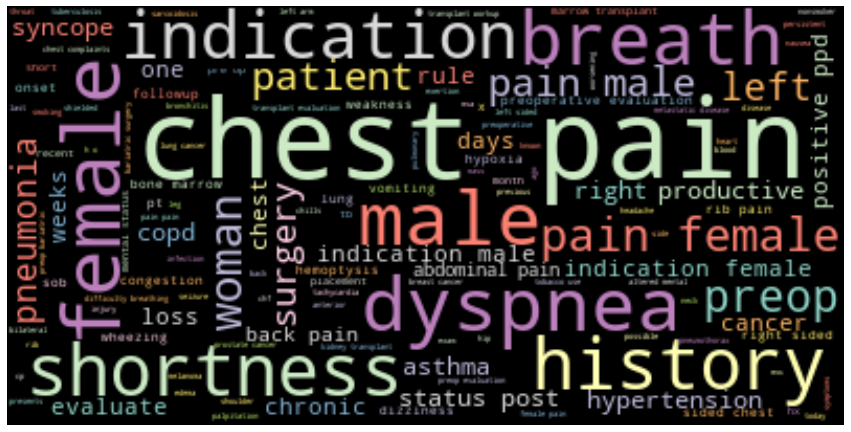

In [39]:
wordcloud = WordCloud(max_words=500, background_color="black", colormap="Set3").generate(' '.join(dataframe['indication'].astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.show()

**Observations for Indication feature :**

* Top two most frequent words are 'no indication' and 'chest pain' above 300 counts in feature.
* In indication feature, 50% data have 7-8 words, 99% text data have less than 10 words in rows. Only 1% data have legnth above 10.
* From wordcloud : chest, pain, shortness, breath, indication are the highlighted words i.e. these are important words.

**Analysis of Findings feature :**

In [40]:
#Printing min,max and median of word_count
print("Minimum number of word count for finding is:",np.min(dataframe.findings_count.values))
print("Maximum number of word count for finding is:",np.max(dataframe.findings_count.values))
print("Median number of word count for finding is:",np.median(dataframe.findings_count.values))

Minimum number of word count for finding is: 2
Maximum number of word count for finding is: 166
Median number of word count for finding is: 26.0


Plotting PDF and CDF for word_count distribution of Findings feature :

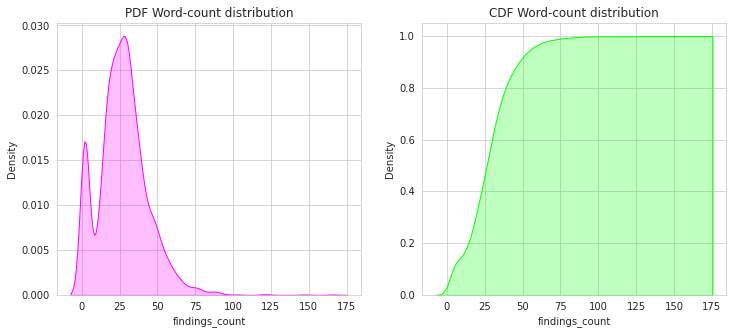

In [55]:
#Plotting the PDF for word_count distribution of Findings feature
plt.figure(figsize = (12,5))
# Seaborn PDF
plt.subplot(121)
sns.kdeplot(dataframe['findings_count'],shade=True,color='Magenta')
plt.title("PDF Word-count distribution")
plt.subplot(122)
# Seaborn CDF
sns.distplot(dataframe['findings_count'], kde_kws={'cumulative': True,'shade': True}, hist=False,color='Lime')
plt.title("CDF Word-count distribution")
plt.show()

Top 50 frequent sentences of Findings feature :

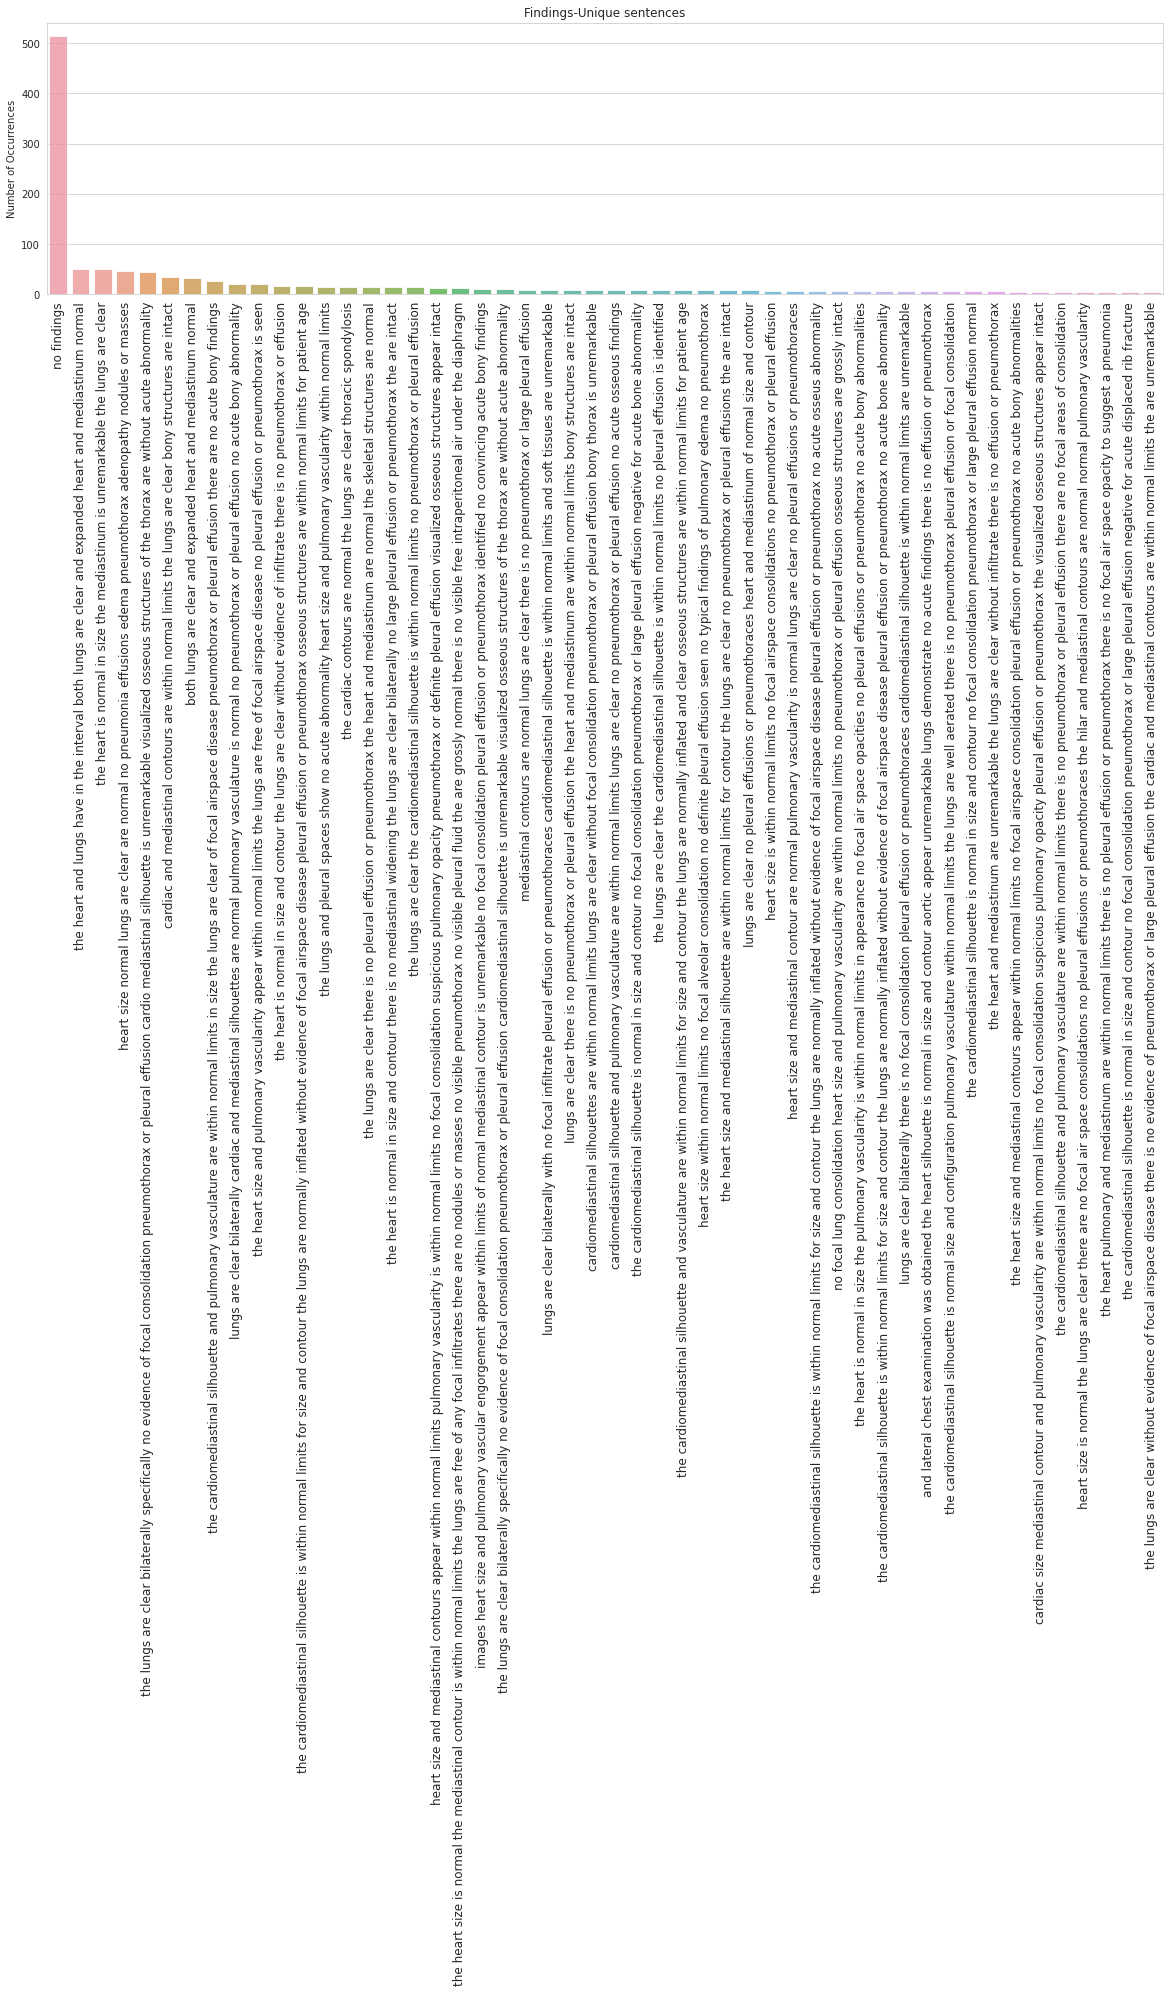

In [56]:
#Plotting top 50 frequent sentences of Findings feature
sentences = dataframe['findings'].value_counts()[:50]
plt.figure(figsize=(20,5))
sns.barplot(sentences.index, sentences.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xticks(fontsize='large',rotation=90)
plt.title("Findings-Unique sentences")
plt.show()

Word cloud on Findings feature : max 500 words

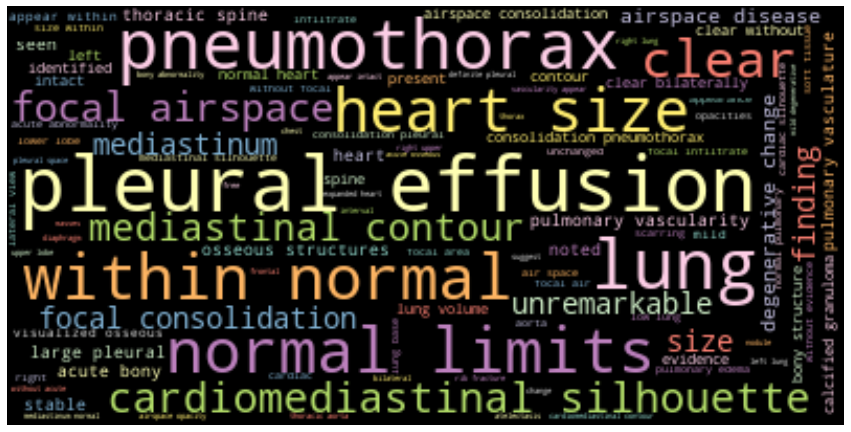

In [57]:
wordcloud = WordCloud(max_words=500, background_color="black", colormap="Set3").generate(' '.join(dataframe['findings'].astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.show()

**Observations for Findings feature :**

* In finding feature, 50% data have less than 20 words per findings, 99% data have less than 48 words per findings. Only 1% data have legnth above 48.
* From wordcloud : pleural, effusion, silhouette, within, normal, lungs, cardiomediastinal are the highlighted words i.e. these are important words.

**Analysis of Target Feature : Impression**

In [44]:
#Printing min,max and median of word_count
print("Minimum number of word count for Impression is:",np.min(dataframe.impression_count.values))
print("Maximum number of word count for Impression is:",np.max(dataframe.impression_count.values))
print("Median number of word count for Impression is:",np.median(dataframe.impression_count.values))

Minimum number of word count for Impression is: 1
Maximum number of word count for Impression is: 123
Median number of word count for Impression is: 5.0


Plotting PDF and CDF for word_count distribution of Impression feature :

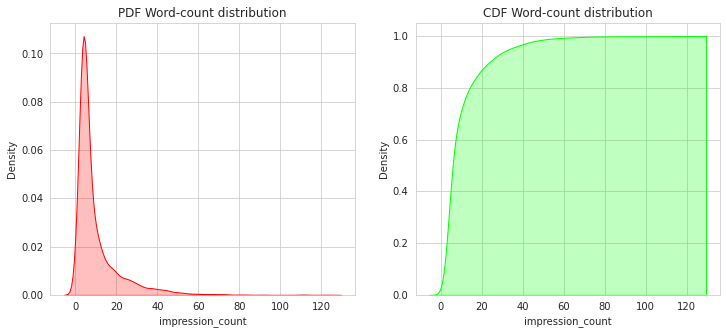

In [58]:
#Plotting PDF and CDF for word_count distribution of Impression feature
plt.figure(figsize = (12,5))
# Seaborn PDF
plt.subplot(121)
sns.kdeplot(dataframe['impression_count'],shade=True,color='Red')
plt.title("PDF Word-count distribution")
plt.subplot(122)
# Seaborn CDF
sns.distplot(dataframe['impression_count'], kde_kws={'cumulative': True,'shade': True}, hist=False,color='Lime')
plt.title("CDF Word-count distribution")
plt.show()

Top 50 frequent sentences of Impression feature :

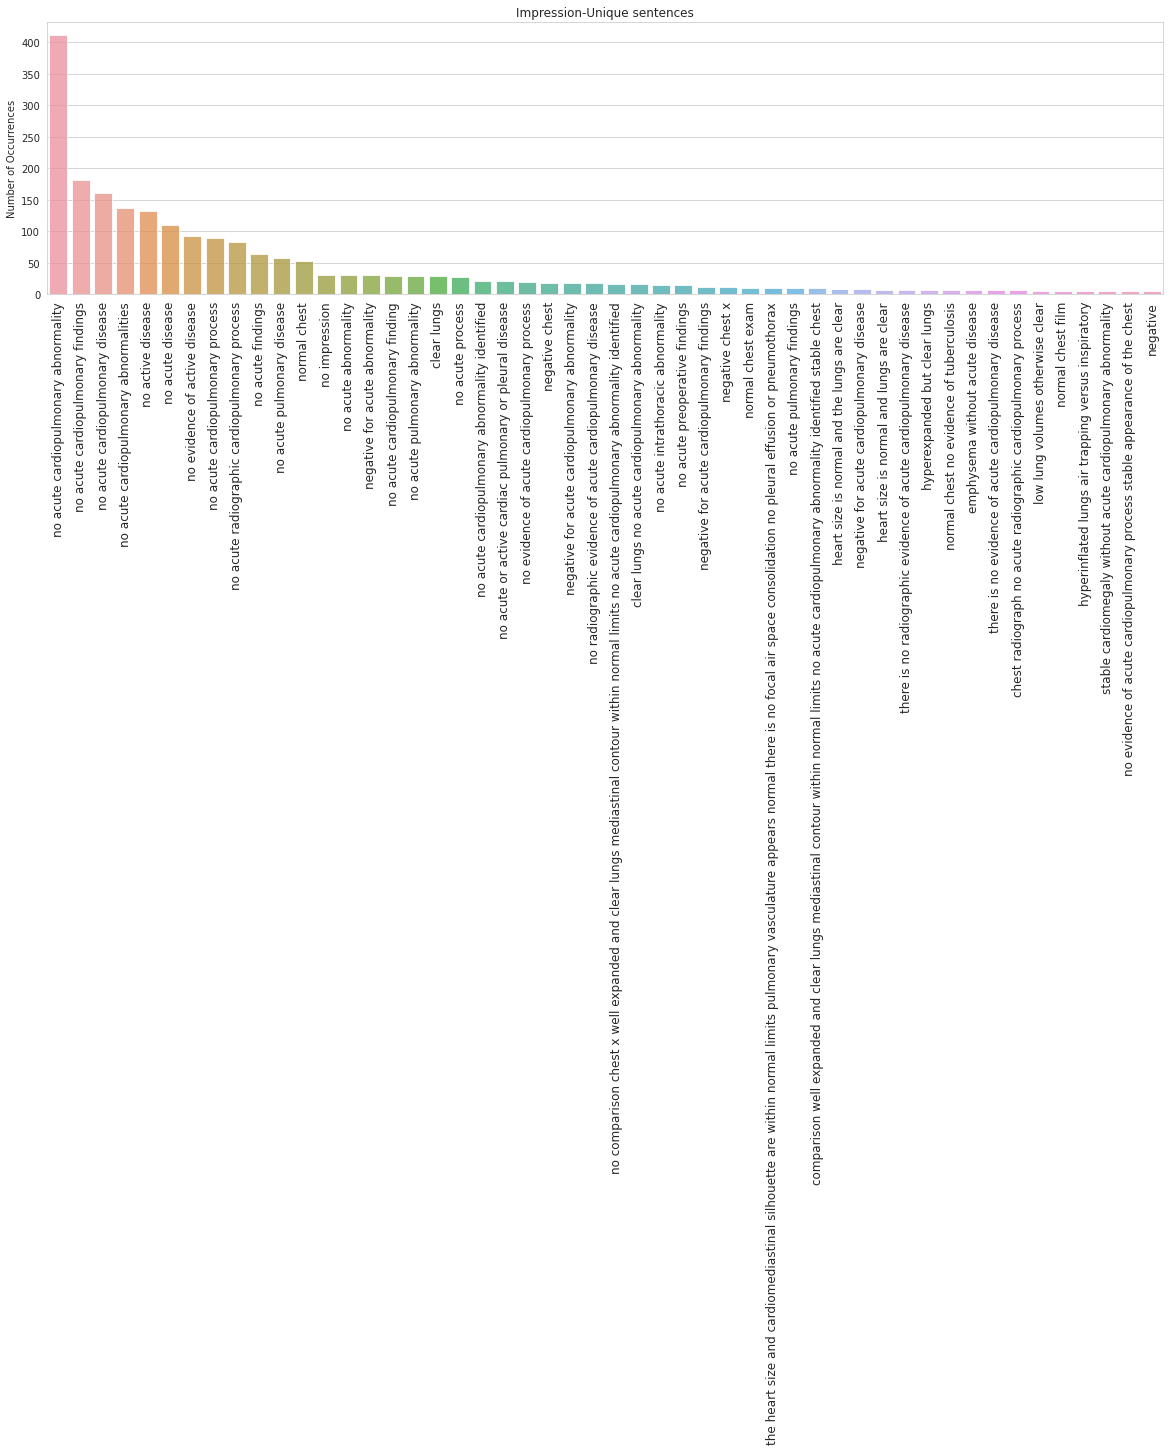

In [59]:
#Plotting top 50 frequent sentences of Impression feature
sentences = dataframe['impression'].value_counts()[:50]
plt.figure(figsize=(20,5))
sns.barplot(sentences.index, sentences.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xticks(fontsize='large',rotation=90)
plt.title("Impression-Unique sentences")
plt.show()

Word cloud on Impression feature : max 500 words

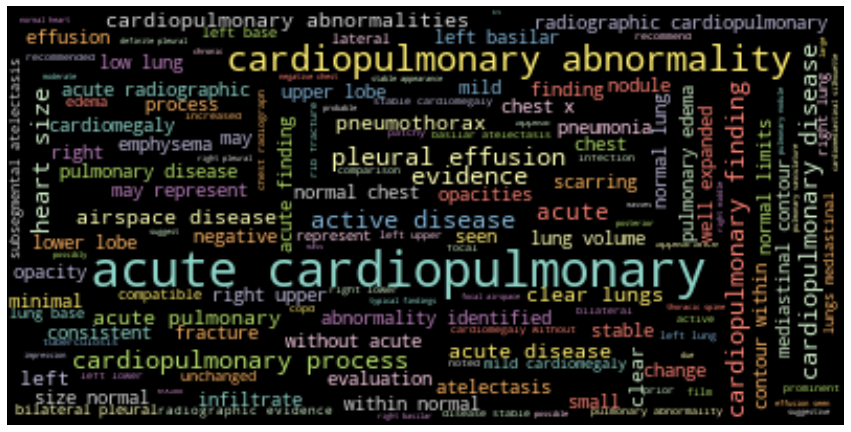

In [61]:
wordcloud = WordCloud(max_words=500, background_color="black", colormap="Set3").generate(' '.join(dataframe['impression'].astype(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.show()

**Observations for Indication feature :**

* Top two most impression are 'no actue cardiopulmonary abnormality' and 'no actue cardiopulmonary findings' above 400 counts in feature.
* In indication feature, 50% data have less than 4 words per impression, it means only few impression have less words. 99% data have less than 39 words per impression. Only 1% data have legnth above 39.
* From wordcloud : actue cardiopulmonary, cardiopulmonary abnormality, disease acute, heart size are the highlighted words i.e. these are important words.

**Total Observations :**

* The dataset contains chest X-ray images and radiology text reports. Each image has been paired with four captions such as Impressions, Findings, Comparison and Indication that provide clear descriptions of the salient entities and events.. All the raw texts from xml files are parsed and created the dataset.

* Images are in different shapes. All the X-Ray images are human upper body particularly about Chest part.

* Each patient have multiple x-rays associated with them. The maximum number of images associated with a report can be 5 while the minimum is 0. The highest frequecy of being associated with a report are 2 images.

* Data is incomplete. Because all the features have few missing values except caption. We have to impute the missing values in data preprocessing step.

* In text features there are some unknown values like XXXX XXXXX these are replaced with empty string.

* We have total of 3955 records and Impression is our target variable.

* Most occurring words of diffrent features:
    > Indication: Chest pain

    > Findings: Pleural effusion

    > Impression: acute cardiopulmonary

* I created wordcloud, for 500 most frequent words of the feature. These are important words. Some of them are: acute, findings, disease, abnormality, high, right, impression, etc.